# 2020-05-07: Data analysis of B4R/PJ020941.3

In [1]:
import tools
from scipy.ndimage import median_filter, uniform_filter
from sklearn.decomposition import TruncatedSVD

median_filter = dataarray_func(median_filter)
uniform_filter = dataarray_func(uniform_filter)

def find_path(dir_path, file_pattern):
    return list(dir_path.glob(file_pattern))[0]

def cov(X):
    X_norm = (X - X.mean("t")) / X.std("t")
    return np.cov(X_norm.T)

## GoDec algorithm for fPSW observations

In [2]:
def estimate_S(X, L, k=25, w=5):
    """Estimate sparse matrix (S)."""
    S = X - L
    phi = S.scantype == "ON"
    spec = S.where(phi).sum("t")
    
    # smooth spectrum (optional)
    if w > 0:
        spec = median_filter(spec, w)

    # k-th largest absolute values -> True
    spec = np.abs(spec)
    theta = (-spec).argsort().argsort() < k
    
    return S * (phi * theta)


def estimate_L(X, S, r=5):
    """Estimate low-rank matrix (L)."""
    R = X - S
    R0 = R.mean("t")

    model = TruncatedSVD(r)
    C = model.fit_transform(R - R0)
    P = model.components_
    L = xr.full_like(X, C @ P) + R0

    return L

## Load data

In [3]:
target = "PJ020941.3"
obsnum_cal = "086889"
obsnum_sci = "086890"
ifnum = "01"
sideband = "LSB"
T_amb = 273.0
ch_bin = 256

nc_cal = find_path(LDATA / target / "xffts", f"*{obsnum_cal}_{ifnum}.nc")
nc_sci = find_path(LDATA / target / "xffts", f"*{obsnum_sci}_{ifnum}.nc")
nc_tel_cal = find_path(LDATA / target / "lmttpm", f"*{obsnum_cal}*.nc")
nc_tel_sci = find_path(LDATA / target / "lmttpm", f"*{obsnum_sci}*.nc")

P_cal = tools.b4r.load_data_xffts(nc_cal, nc_tel_cal, sideband)
P_sci = tools.b4r.load_data_xffts(nc_sci, nc_tel_sci, sideband)

phi = P_sci.scantype == "ON"

## Reduce data by chopper-wheel calibration and linear baseline

In [4]:
T_cal_org = tools.b4r.calibrate_intensity(P_sci, P_cal, T_amb)
T_cal_org = tools.b4r.bin_channels(T_cal_org, ch_bin)

weight = (T_cal_org.ch < 129.4) | (T_cal_org.ch > 129.9)
T_base = tools.b4r.estimate_baseline(T_cal_org.fillna(0), weight=weight)
T_cal = (T_cal_org - T_base).where(phi, drop=True)

100%|██████████| 30/30 [00:00<00:00, 61.62it/s]


## Reduce data by the GoDec algorithm for fPSW observations

In [5]:
dP = P_sci - P_cal.where(P_cal.scanid == 0).mean("t")
dP = tools.b4r.bin_channels(dP, ch_bin)
X = np.log(-dP/T_amb)

### With smoothing spectrum

In [6]:
r = 5
k = 25
w = 5

S = xr.zeros_like(X)

for i in tqdm(range(100)):
    L = estimate_L(X, S, r=r)
    S = estimate_S(X, L, k=k, w=w)

T_cal_re = T_amb * (1-np.exp(X-L))
T_cal_re = T_cal_re.where(phi, drop=True)

print(f"Nonzero: {(S!=0).sum().values/S.size:.1%}")

100%|██████████| 100/100 [00:01<00:00, 88.73it/s]

Nonzero: 9.7%


### Without smoothing spectrum

In [7]:
S = xr.zeros_like(X)

for i in tqdm(range(100)):
    L = estimate_L(X, S, r=r)
    S = estimate_S(X, L, k=k, w=0)

T_cal_re_w0 = T_amb * (1-np.exp(X-L))
T_cal_re_w0 = T_cal_re_w0.where(phi, drop=True)

print(f"Nonzero: {(S!=0).sum().values/S.size:.1%}")

100%|██████████| 100/100 [00:00<00:00, 105.39it/s]

Nonzero: 9.7%


## Make spectra and plot

In [8]:
weight = T_cal.std("ch") ** -2
spec = (weight * T_cal).sum("t") / weight.sum("t")

weight_re = T_cal_re.std("ch") ** -2
spec_re = (weight_re * T_cal_re).sum("t") / weight_re.sum("t")

weight_re_w0 = T_cal_re_w0.std("ch") ** -2
spec_re_w0 = (weight_re_w0 * T_cal_re_w0).sum("t") / weight_re_w0.sum("t")

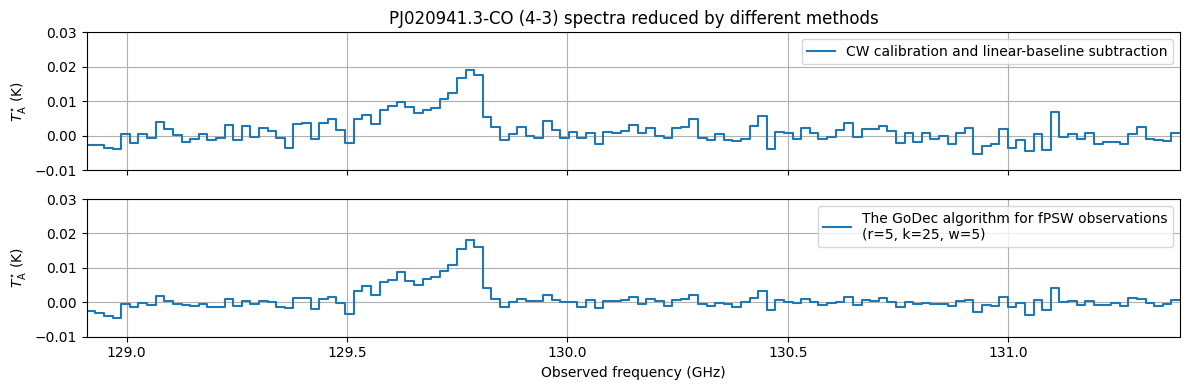

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4), dpi=100)

ax = axes[0]
ax.step(spec.ch, spec, label="CW calibration and linear-baseline subtraction")
ax.set_title(f"{target}-CO (4-3) spectra reduced by different methods")
ax.set_ylabel(r"$T_{\mathrm{A}}^{\star}$ (K)")
ax.set_xlim(spec.ch.min(), spec.ch.max())
ax.set_ylim(-0.01, 0.03)
ax.legend()
ax.grid()

ax = axes[1]
ax.step(spec.ch, spec_re, label=f"The GoDec algorithm for fPSW observations\n(r={r}, k={k}, w={w})")
ax.set_xlabel("Observed frequency (GHz)")
ax.set_ylabel(r"$T_{\mathrm{A}}^{\star}$ (K)")
ax.set_ylim(-0.01, 0.03)
ax.legend()
ax.grid()

fig.tight_layout()
savefig_in_notebook(fig, "spectra-PJ020941.3-CO43.pdf")

/Users/akio/Library/Caches/pypoetry/virtualenvs/reform-analysis-KfK74LQw-py3.7/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/akio/Library/Caches/pypoetry/virtualenvs/reform-analysis-KfK74LQw-py3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/akio/Library/Caches/pypoetry/virtualenvs/reform-analysis-KfK74LQw-py3.7/lib/python3.7/site-packages/xarray/core/dataarray.py:1924: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


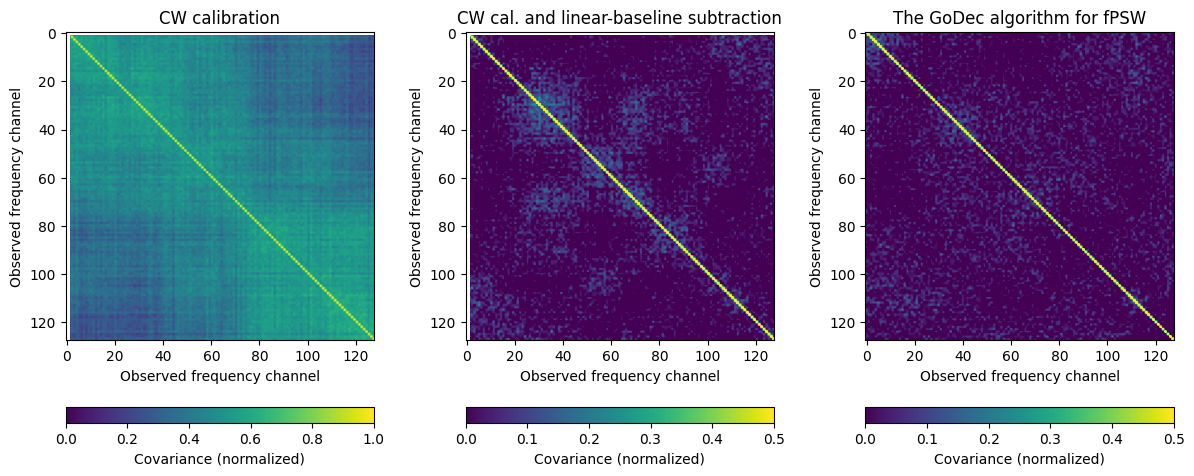

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5), dpi=100)

ax = axes[0]
im = ax.imshow(cov(T_cal_org), vmin=0, vmax=1)
ax.set_title("CW calibration")
fig.colorbar(im, ax=ax, orientation="horizontal", label="Covariance (normalized)")

ax = axes[1]
im = ax.imshow(cov(T_cal), vmin=0, vmax=0.5)
ax.set_title("CW cal. and linear-baseline subtraction")
fig.colorbar(im, ax=ax, orientation="horizontal", label="Covariance (normalized)")

ax = axes[2]
im = ax.imshow(cov(T_cal_re), vmin=0, vmax=0.5)
ax.set_title("The GoDec algorithm for fPSW")
fig.colorbar(im, ax=ax, orientation="horizontal", label="Covariance (normalized)")

for ax in axes.flatten():
    ax.set_xlabel("Observed frequency channel")
    ax.set_ylabel("Observed frequency channel")

fig.tight_layout()
savefig_in_notebook(fig, "covariance-PJ020941.3-CO43.pdf")

## Observed time vs noise level (standard deviation)

In [11]:
T_base = xr.concat([T_cal.loc[:, :129.4], T_cal.loc[:, 129.9:]], "ch")
T_base_re = xr.concat([T_cal_re.loc[:, :129.4], T_cal_re.loc[:, 129.9:]], "ch")

cumstd = (T_base.cumsum("t") / xr.ones_like(T_base).cumsum("t")).std("ch")
cumstd_re = (T_base_re.cumsum("t") / xr.ones_like(T_base_re).cumsum("t")).std("ch")
cumint = T_base.integtime.cumsum("t")

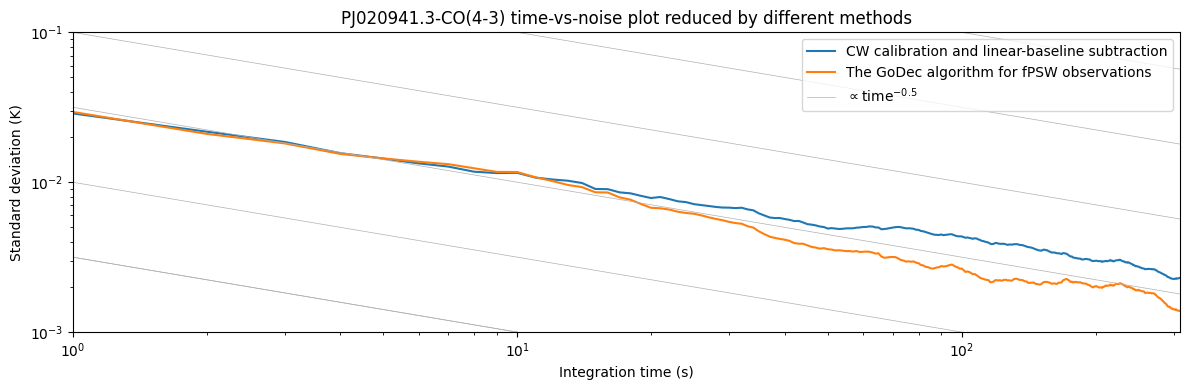

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)

ax.plot(cumint, cumstd, label="CW calibration and linear-baseline subtraction")
ax.plot(cumint, cumstd_re, label="The GoDec algorithm for fPSW observations")

for i, dex in enumerate([-2.5, -2.0, -1.5, -1.0, -0.5, 0.0]):
    if i == 0:
        label = "$\propto \mathrm{time}^{-0.5}$"
        ax.plot(cumint, 10**dex * cumint**-0.5, lw=0.5, c="#b0b0b0", label=label)
    
    ax.plot(cumint, 10**dex * cumint**-0.5, lw=0.5, c="#b0b0b0")

# ax.set_title(f"{target}, Obsnum: {obsnum_cal}-{obsnum_sci}, IF: {ifnum} ({sideband})")
ax.set_title(f"{target}-CO(4-3) time-vs-noise plot reduced by different methods")
ax.set_xlabel("Integration time (s)")
ax.set_ylabel("Standard deviation (K)")
ax.set_xlim(cumint.min(), cumint.max())
ax.set_ylim(1e-3, 1e-1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right")

fig.tight_layout()
savefig_in_notebook(fig, "time-vs-noise-PJ020941.3-CO43.pdf")